When finished, save as HTML and then save webpage as PDf

ECON 771 - Empirical Replication 1

Emerson Hamer

April 26 2024

In [1]:
# Preliminaries -----------------------------------------------------------
if (!require("pacman")) install.packages("pacman")
library(pacman)
pacman::p_load(tidyverse, ggplot2, dplyr, lubridate, stargazer, 
               withr, fixest, modelsummary, did, xtable)
               
setwd('/Users/emersonhamer/Projects/EC-771-Empirical')

Loading required package: pacman



In [2]:
# import data
dataset_list <- c("HCRIS_Data", "medicaid_expansion", "pos_data_combined")
for (i in dataset_list){
  assign( paste0(i, ".df"),
          read.table(paste0("data/output/", i ,".txt"),
                     header = TRUE, fill = TRUE, 
                     colClasses=c("character"),
                     check.names = FALSE,
                     sep = '\t', quote = "")
                       )
}

In [3]:
#More cleaning

# Medicaid_expansion
medicaid_expansion.df <- medicaid_expansion.df %>%
    mutate(year = format(as.Date(medicaid_expansion.df$date_adopted), format="%Y")) %>%
    rename(year_expand = year, state = state_abb, expanded_ever = expanded) %>% 
    select(expanded_ever, state, year_expand)

# POS
pos_data_combined.df <- pos_data_combined.df %>%
  rename(provider_number = provider) %>%
  filter(category == "Hospital") %>%
  select(provider_number, state, own_type, year)%>%
  mutate(private = ifelse( own_type == "Non-profit Private" | own_type == "Profit" , 1, 0),
         non_profit_private = ifelse( own_type == "Non-profit Private" , 1, 0))

# HCRIS
HCRIS_Data.df <- HCRIS_Data.df %>%
  filter(year>=2003 & year <=2019) %>%
  select(provider_number, uncomp_care, tot_pat_rev, year)

In [4]:

# Merge

full.data <- HCRIS_Data.df %>%
  left_join(pos_data_combined.df,
            by = c("provider_number", "year")) %>%
  left_join(medicaid_expansion.df, 
            by = "state") %>%
  drop_na(uncomp_care, tot_pat_rev, expanded_ever) %>%
  
  transform(uncomp_care = as.numeric(uncomp_care), 
            tot_pat_rev = as.numeric(tot_pat_rev),
            year = as.numeric(year), 
            year_expand = as.numeric(year_expand),
            expanded_ever = as.integer(as.logical(expanded_ever))) %>%
  transform(uncomp_care = uncomp_care/1000000, 
            tot_pat_rev = tot_pat_rev/1000000, 
            year = as.numeric(year)) %>%
  mutate(expanded_t = ifelse(year < year_expand | is.na(year_expand), 0, 1))


In [5]:

trim.data <- full.data %>%
  group_by(year) %>%
  mutate(ptile_uncomp=ntile(uncomp_care,100)) %>%
  filter(ptile_uncomp>1 & ptile_uncomp<99)

Q1. Provide and discuss a table of simple summary statistics showing the mean, standard deviation, min, and max of hospital total revenues and uncompensated care over time.

A1. Code:

In [6]:
options(xtable.comment = FALSE)

In [7]:
#Total Revenue 
combined.rev.df <- trim.data %>%
  group_by(year) %>% 
  summarize(
    mean = mean(tot_pat_rev, na.rm = TRUE), 
    std_dev = sd(tot_pat_rev, na.rm = TRUE),
    min = min(tot_pat_rev, na.rm = TRUE),
    max = max(tot_pat_rev, na.rm = TRUE)
  )
# print(xtable(combined.rev.df, caption = "Total Revenue", label = "tab:rev", digits = 2), type = "latex")
#xt_tot_rev = xtable(combined.rev.df,
#              caption = "Summary statistics of total hospital revenus")
#names(xt_tot_rev) <- c('Year', 'Mean','SD','Min', 'Max')
#print(xt_tot_rev, include.rownames=FALSE)

# Rename columns
colnames(combined.rev.df) <- c('Year', 'Mean','SD','Min', 'Max')
# Print table with knitr::kable
knitr::kable(combined.rev.df, caption = "Summary statistics of total revenues")
saveRDS(combined.rev.df, "combined_rev_df.rds")



Table: Summary statistics of total revenues

| Year|     Mean|        SD|      Min|       Max|
|----:|--------:|---------:|--------:|---------:|
| 2003| 282.0957|  377.3738| 1.661279|  4722.759|
| 2004| 314.8991|  422.7317| 1.367956|  5525.731|
| 2005| 365.0104|  483.3667| 2.743521|  6398.554|
| 2006| 414.7434|  519.5697| 2.546381|  6718.170|
| 2007| 463.9195|  606.3039| 1.822361|  8577.046|
| 2008| 496.1240|  614.9635| 0.968848|  7743.079|
| 2009| 534.2063|  669.7063| 0.889880|  9139.322|
| 2010| 545.1636|  685.2878| 0.837087|  8058.136|
| 2011| 544.3636|  749.5600| 1.649644| 10572.291|
| 2012| 576.0434|  786.3345| 1.454817|  8910.683|
| 2013| 624.4004|  879.3617| 2.612320| 10425.156|
| 2014| 686.7163|  975.2565| 2.946986| 11519.386|
| 2015| 741.9993| 1046.7831| 2.493771| 14143.533|
| 2016| 836.2833| 1223.6859| 2.223392| 14998.229|
| 2017| 844.2258| 1326.6076| 1.719896| 16305.915|
| 2018| 846.5194| 1362.2449| 1.330962| 17968.318|
| 2019| 888.3107| 1491.0895| 3.000680| 18078.508|

A1. Comments about summary statistics of total revenue:
The mean hospital revenue is increasing over time.  The highest maximum total revenue is reached in 2019, and the lowest minumum revenue is in 2010. 

In [8]:

#Uncompensated Care
combined.uncomp.df <- trim.data %>%
  mutate(year = as.character(year)) %>%
  group_by(year) %>% 
  summarize(
    mean = mean(uncomp_care, na.rm = TRUE), 
    std_dev = sd(uncomp_care, na.rm = TRUE),
    min = min(uncomp_care, na.rm = TRUE),
    max = max(uncomp_care, na.rm = TRUE)
    )

# Rename columns
colnames(combined.uncomp.df) <- c('Year', 'Mean','SD','Min', 'Max')

# Print table with knitr::kable
knitr::kable(combined.uncomp.df, caption = "Summary statistics of uncompensated care")

saveRDS(combined.uncomp.df, "combined_uncomp_df.rds")

# print(xtable(combined.uncomp.df, caption = "Uncompensated Care", label = "tab:uncomp", digits = 2), type = "latex")



Table: Summary statistics of uncompensated care

|Year |     Mean|       SD|      Min|      Max|
|:----|--------:|--------:|--------:|--------:|
|2003 | 10.40714| 15.74236| 0.001853| 101.6726|
|2004 | 11.76737| 16.51085| 0.015494| 101.5250|
|2005 | 13.77857| 18.72244| 0.030485| 118.5544|
|2006 | 16.53693| 21.61625| 0.031658| 137.8008|
|2007 | 18.72037| 24.09424| 0.035723| 148.9607|
|2008 | 21.44116| 27.97169| 0.047645| 169.6982|
|2009 | 23.45368| 29.73962| 0.031418| 177.4171|
|2010 | 24.56769| 31.15714| 0.038817| 182.0271|
|2011 | 27.01232| 35.22928| 0.044502| 230.8455|
|2012 | 29.02267| 38.05499| 0.099482| 248.5752|
|2013 | 31.29890| 39.70698| 0.103560| 240.6196|
|2014 | 27.15226| 35.42057| 0.128942| 202.7593|
|2015 | 24.20825| 33.05440| 0.092496| 206.8791|
|2016 | 29.88385| 42.13431| 0.151073| 258.5248|
|2017 | 31.86972| 46.31733| 0.131704| 273.2484|
|2018 | 31.34580| 46.08980| 0.157030| 263.0785|
|2019 | 37.76776| 65.98856| 0.108662| 436.4199|

A1. Comments

The mean uncompensated care is generally increasing over time, with a small decrease from 2013-2015.  The highest maximum uncompensated care is reached in 2019, and the lowest minumum uncompensated care is in 2003. 

Q2. Create a figure showing the mean hospital uncompensated care from 2003 to 2019. Show this trend separately by hospital ownership type (private not for profit and private for profit).

A2. Code

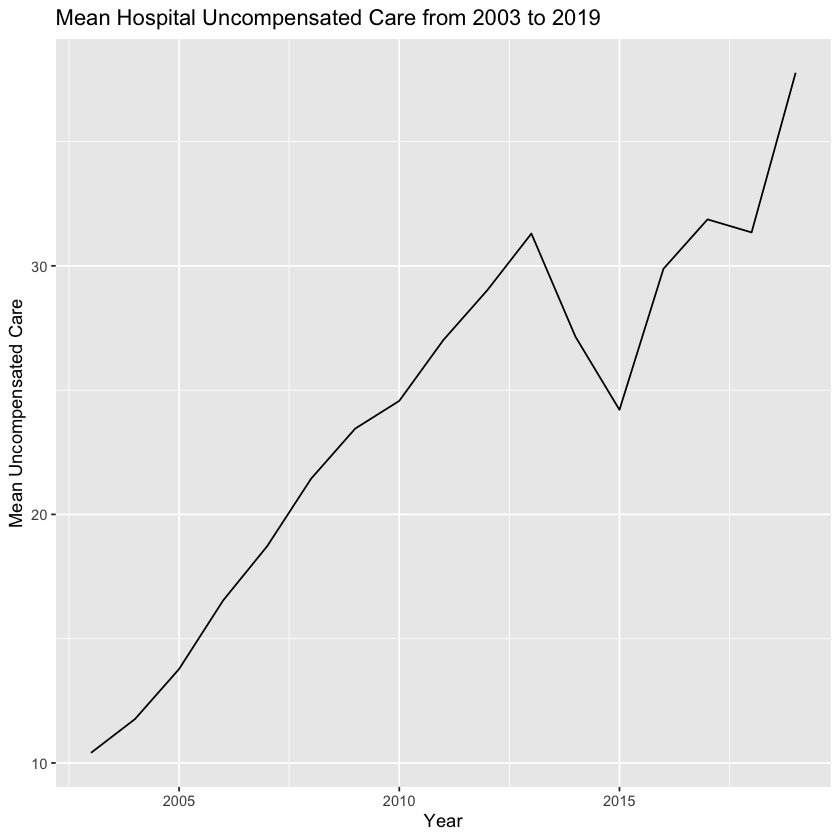

In [9]:
# Load the necessary library
library(ggplot2)

# Calculate mean uncompensated care by year
mean_uncomp_care_by_year <- trim.data %>%
  filter(year >= 2003 & year <= 2019) %>%
  group_by(year) %>%
  summarize(mean_uncomp_care = mean(uncomp_care, na.rm = TRUE))

# Create the plot
ggplot(mean_uncomp_care_by_year, aes(x = year, y = mean_uncomp_care)) +
  geom_line() +
  labs(x = "Year", y = "Mean Uncompensated Care", 
       title = "Mean Hospital Uncompensated Care from 2003 to 2019")

# Save the plot
saveRDS(mean_uncomp_care_by_year, "mean_uncomp_care_by_year.rds")

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


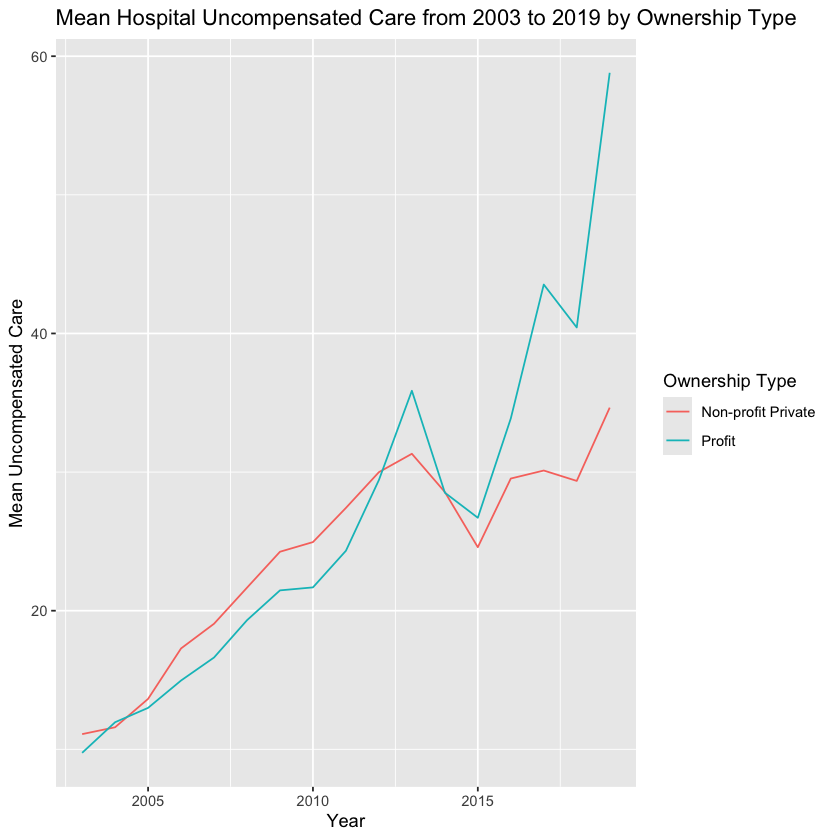

In [10]:


# Calculate mean uncompensated care by year and ownership type
mean_uncomp_care_by_year <- trim.data %>%
  filter(private ==1) %>%
  filter(year >= 2003 & year <= 2019) %>%
  group_by(year, own_type) %>%
  summarize(mean_uncomp_care = mean(uncomp_care, na.rm = TRUE))

# Create the plot
ggplot(mean_uncomp_care_by_year, aes(x = year, y = mean_uncomp_care, color = own_type)) +
  geom_line() +
  labs(x = "Year", y = "Mean Uncompensated Care", 
       title = "Mean Hospital Uncompensated Care from 2003 to 2019 by Ownership Type") +
  scale_color_discrete(name = "Ownership Type")

# Save the plot
saveRDS(mean_uncomp_care_by_year, "mean_uncomp_care_by_year_ownership.rds")

In [11]:
remotes::install_github ("asheshrambachan/HonestDiD", force = TRUE)
install.packages("devtools")
devtools::install_github("bcallaway11/BMisc", dependencies = TRUE)
library(HonestDiD)

Using GitHub PAT from the git credential store.




ggplot2 (3.5.0 -> 3.5.1) [CRAN]


Installing 1 packages: ggplot2




The downloaded binary packages are in
	/var/folders/99/lmwmsfzx57x8kj4r0gbr8mxw0000gn/T//RtmpNq55MM/downloaded_packages
-- R CMD build -----------------------------------------------------------------
* checking for file '/private/var/folders/99/lmwmsfzx57x8kj4r0gbr8mxw0000gn/T/RtmpNq55MM/remotes77e93b3f93fa/asheshrambachan-HonestDiD-99e05c7/DESCRIPTION' ... OK
* preparing 'HonestDiD':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building 'HonestDiD_0.2.6.tar.gz'


The downloaded binary packages are in
	/var/folders/99/lmwmsfzx57x8kj4r0gbr8mxw0000gn/T//RtmpNq55MM/downloaded_packages


Using GitHub PAT from the git credential store.

Skipping install of 'BMisc' from a github remote, the SHA1 (76454077) has not changed since last install.
  Use `force = TRUE` to force installation



Q3. Using a simple DD identification strategy, estimate the effect of Medicaid expansion on hospital uncompensated care using a traditional two-way fixed effects (TWFE) estimation:

where in Equation @ref(eq:dd) is an indicator set to 1 when a hospital is in a state that expanded as of year or earlier, 
 denotes time fixed effects, 
 denotes hospital fixed effects, and 
 denotes the hospital’s amount of uncompensated care in year 
. Present four estimates from this estimation in a table: one based on the full sample (regardless of treatment timing); one when limiting to the 2014 treatment group (with never treated as the control group); one when limiting to the 2015 treatment group (with never treated as the control group); and one when limiting to the 2016 treatment group (with never treated as the control group). Briefly explain any differences.

In [12]:
reg.data1 <- trim.data %>% 
  mutate(uncomp_care=uncomp_care/1000) %>%
  mutate(treat=
           case_when(
             year>=year_expand & !is.na(year_expand) ~ 1,
             year<year_expand & !is.na(year_expand) ~0,
             is.na(year_expand) ~ 0
           )
         )

reg.data2 <- trim.data %>% 
  mutate(uncomp_care=uncomp_care/1000) %>%
  filter(is.na(year_expand) | year_expand==2014) %>%
  mutate(post=(year>=2014),
         treat=post*expanded_ever)

reg.data3 <- trim.data %>% 
  mutate(uncomp_care=uncomp_care/1000) %>%
  filter(is.na(year_expand) | year_expand==2015) %>%
  mutate(post=(year>=2015),
         treat=post*expanded_ever)

reg.data4 <- trim.data %>% 
  mutate(uncomp_care=uncomp_care/1000) %>%
  filter(is.na(year_expand) | year_expand==2016) %>%
  mutate(post=(year>=2016),
         treat=post*expanded_ever)

dd.est1 <- feols(uncomp_care~treat | year + provider_number, data=reg.data1)
dd.est2 <- feols(uncomp_care~treat | year + provider_number, data=reg.data2)
dd.est3 <- feols(uncomp_care~treat | year + provider_number, data=reg.data3)
dd.est4 <- feols(uncomp_care~treat | year + provider_number, data=reg.data4)

sum.fmt <- function(x) formatC(x, digits = 2, big.mark = ",", format = "f")
dd.summary <- msummary(list("Full Sample"=dd.est1, "Expand 2014"=dd.est2, 
                            "Expand 2015"=dd.est3, "Expand 2016"=dd.est4),
                       shape=term + statistic ~ model, 
                       gof_map=NA,
                       coef_omit='Intercept',
                       coef_rename=c("treat"="Expansion"),
                       fmt= sum.fmt,
                       vcov = ~provider_number,
                       output="markdown",
                       caption="TWFE Estimates for Different Treatment Groups",
                       label="ddmodels")

In [13]:
dd.summary
saveRDS(dd.summary, "dd_summary.rds")


+-----------+-------------+-------------+-------------+-------------+
|           | Full Sample | Expand 2014 | Expand 2015 | Expand 2016 |
+===========+=============+=============+=============+=============+
| Expansion | -0.02       | -0.02       | -0.02       | -0.02       |
+-----------+-------------+-------------+-------------+-------------+
|           | (0.00)      | (0.00)      | (0.00)      | (0.00)      |
+-----------+-------------+-------------+-------------+-------------+ 

Q4. Estimate an “event study” version of the specification in part 3:
 
 
where 
 in Equation @ref(eq:event) is essentially an interaction between the treatment dummy and a relative time dummy. In this notation and context, 
 denotes years relative to Medicaid expansion, so that 
 denotes the year before a state expanded Medicaid, 
 denotes the year of expansion, etc. Estimate with two different samples: one based on the full sample and one based only on those that expanded in 2014 (with never treated as the control group).

In [14]:
# This doesnt work 
## based on full data
event.data1 <- reg.data1 %>%
  mutate(event_time= case_when(
             !is.na(year_expand) ~ year-year_expand,
             is.na(year_expand) ~ -1
           )
         ) 

event.reg1 <- feols(uncomp_care ~ i(as.factor(event_time), expanded_ever, ref=-1) | year + provider_number, 
                   cluster=~provider_number, data=event.data1)


## based on 2014 treatment group only
event.reg2 <- feols(uncomp_care ~ i(as.factor(year), expanded_ever, ref=2013) | year + provider_number, 
                    cluster=~provider_number, data=reg.data2)

Q5. Sun and Abraham (SA) show that the 
 coefficients in Equation @ref(eq:event) can be written as a non-convex average of all other group-time specific average treatment effects. They propose an interaction weighted specification:
  
 
Re-estimate your event study using the SA specification in Equation @ref(eq:iwevent). Show your results for 
 in a Table, focusing on states with 
, 
, and 
.

In [15]:
sa.data <- event.data1 %>%
  mutate(year_expand = ifelse(expanded_ever==FALSE, 10000, year_expand),
         time_to_treat = ifelse(expanded_ever==FALSE, -1, year-year_expand),
         time_to_treat = ifelse(time_to_treat < -15, -15, time_to_treat))

sa.reg <- feols(uncomp_care ~ sunab(year_expand, time_to_treat) | year + provider_number,
                cluster=~provider_number, data=sa.data)
sa.est <- tidy(summary(sa.reg, agg=FALSE)) %>%
  filter(str_detect(term,"cohort::2014|cohort::2015|cohort::2016")) %>%
  mutate(term=str_replace(term,"time_to_treat::",""),
         term=str_replace(term,":cohort::",":")) %>%
  separate(term,c("period","cohort"),":") %>%
  mutate(period=as.numeric(period)) %>%
  select(period, cohort, estimate, p.value) %>%
  rename(p_value=p.value) 

Q6. Present an event study graph based on the results in part 5. Hint: you can do this automatically in R with the fixest package (using the sunab syntax for interactions), or with eventstudyinteract in Stata. These packages help to avoid mistakes compared to doing the tables/figures manually and also help to get the standard errors correct.

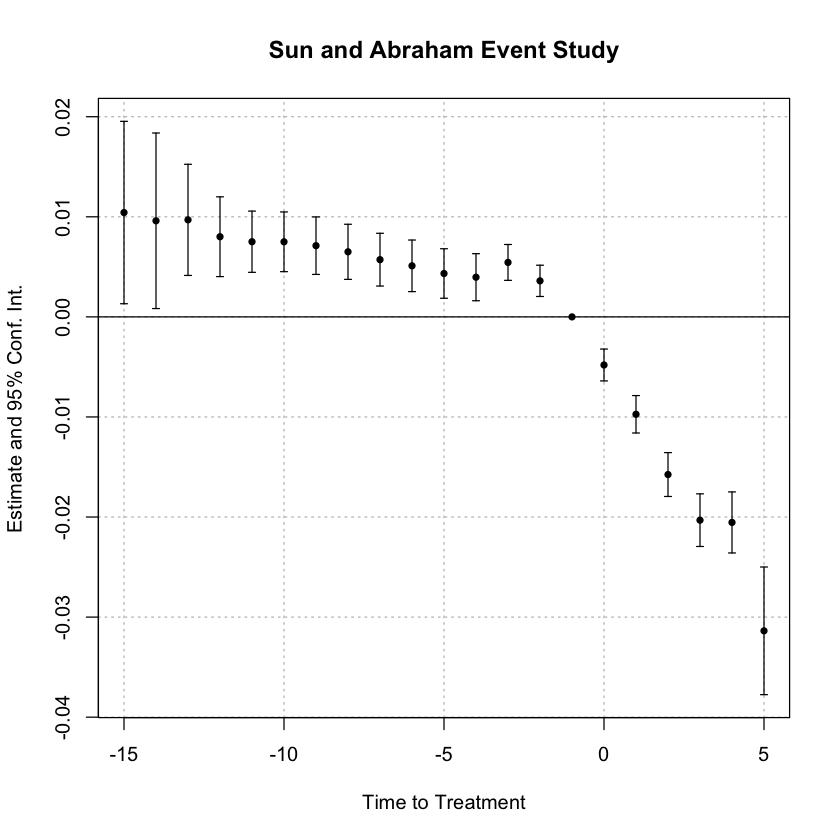

In [16]:
#Event study plot
sa.event.plot <- iplot(sa.reg, xlab = "Time to Treatment", main="Sun and Abraham Event Study")

# Save the plot
saveRDS(sa.event.plot, "sa_event_plot.rds")

Q7. Callaway and Sant’Anna (CS) offer a non-parametric solution that effectively calculates a set of group-time specific differences, 
, where 
 reflects treatment timing and 
 denotes time. They show that under the standard DD assumptions of parallel trends and no anticipation, 
, so that 
 is directly estimable from sample analogs. CS also propose aggregations of 
 to form an overall ATT or a time-specific ATT (e.g., ATTs for 
 periods before/after treatment). With this framework in mind, provide an alternative event study using the CS estimator. Hint: check out the did package in R or the csdid package in Stata.

In [17]:
library(scales)


Attaching package: 'scales'


The following object is masked from 'package:fixest':

    pvalue


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




In [18]:
install.packages("scales")


The downloaded binary packages are in
	/var/folders/99/lmwmsfzx57x8kj4r0gbr8mxw0000gn/T//RtmpNq55MM/downloaded_packages


In [19]:
cs.data <- reg.data1 %>%
  mutate(year_expand=ifelse(is.na(year_expand),0,year_expand)) %>%
  group_by(provider_number) %>%
  mutate(hospital_id=cur_group_id()) %>% ungroup()


cs.mod <- att_gt(yname="uncomp_care", tname="year", idname="hospital_id",
                 gname="year_expand",
                 data=cs.data, panel=TRUE, est_method="dr",
                 allow_unbalanced_panel=TRUE)
cs.event <- aggte(cs.mod, type="dynamic")

coef.cs <- tidy(cs.event) %>%
  select(rel_year=event.time, estimate, ci_lower=conf.low, ci_upper=conf.high) %>%
  mutate(rel_year=as.numeric(rel_year))
coef.cs <- as_tibble(coef.cs)

cs.plot <- ggplot(coef.cs, aes(x=rel_year, y=estimate)) + 
  geom_point(size = 2)  +
  geom_linerange(aes(ymin = ci_lower, ymax = ci_upper)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  geom_vline(xintercept = -0.5, linetype = "dashed") +
  theme(legend.position="none") +
  scale_x_continuous(breaks = -15:5, minor_breaks = NULL) +
  scale_y_continuous(minor_breaks = NULL, label=comma) +
  labs(x = "Relative Time", y = "Estimated Effect, $1000s", color = NULL, title = NULL) +
  theme_bw()

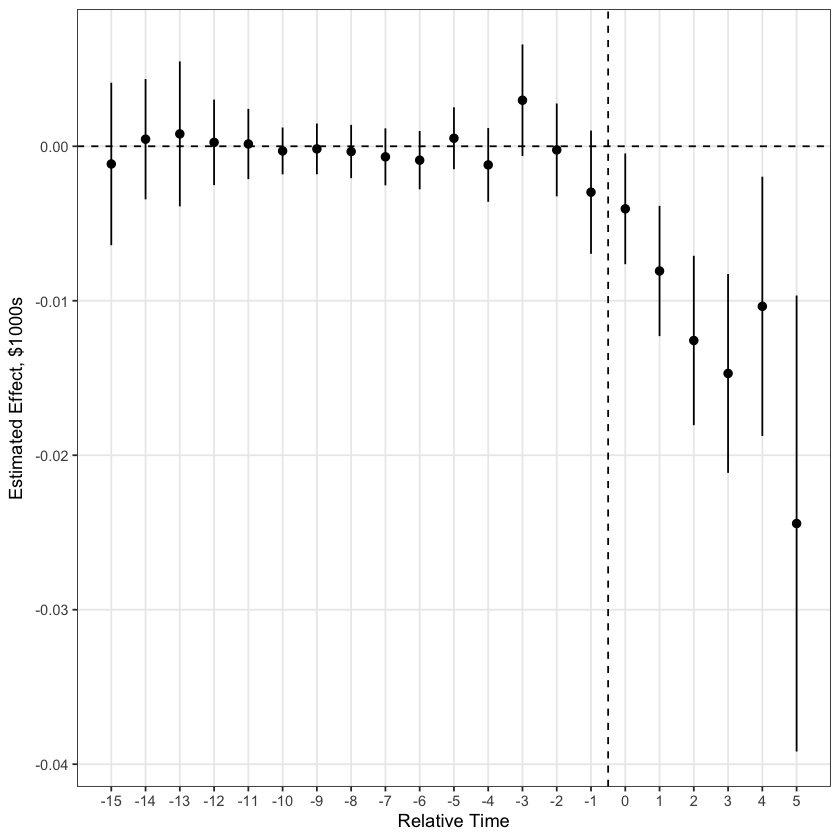

In [20]:
cs.plot

# Save the plot
saveRDS(cs.plot, "cs_plot.rds")

Q8. Rambachan and Roth (RR) show that traditional tests of parallel pre-trends may be underpowered, and they provide an alternative estimator that essentially bounds the treatment effects by the size of an assumed violation in parallel trends. One such bound RR propose is to limit the post-treatment violation of parallel trends to be no worse than some multiple of the pre-treatment violation of parallel trends. Assuming linear trends, such a relative violation is reflected by
 
The authors also propose a similar approach with what they call “smoothness restrictions,” in which violations in trends changes no more than 
 between periods. The only difference is that one restriction is imposed relative to observed trends, and one restriction is imposed using specific values. Using the HonestDiD package in R or Stata, present a sensitivity plot of your CS ATT estimates using smoothness restrictions, with assumed violations of size 
. Check out the GitHub repo here for some help in combining the HonestDiD package with CS estimates. Note that you’ll need to edit the function in that repo in order to use pre-specified smoothness restrictions. You can do that by simply adding Mvec=Mvec in the createSensitivityResults function for type=smoothness.



In [21]:
library(did)
install.packages("did")


The downloaded binary packages are in
	/var/folders/99/lmwmsfzx57x8kj4r0gbr8mxw0000gn/T//RtmpNq55MM/downloaded_packages


In [25]:
remotes::install_github ("asheshrambachan/HonestDiD", force = TRUE)
install.packages("devtools")
devtools::install_github("bcallaway11/BMisc", dependencies = TRUE)
library(HonestDiD)

Using GitHub PAT from the git credential store.





-- R CMD build -----------------------------------------------------------------
* checking for file '/private/var/folders/99/lmwmsfzx57x8kj4r0gbr8mxw0000gn/T/RtmpNq55MM/remotes77e920119f25/asheshrambachan-HonestDiD-99e05c7/DESCRIPTION' ... OK
* preparing 'HonestDiD':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building 'HonestDiD_0.2.6.tar.gz'


The downloaded binary packages are in
	/var/folders/99/lmwmsfzx57x8kj4r0gbr8mxw0000gn/T//RtmpNq55MM/downloaded_packages


Using GitHub PAT from the git credential store.

Skipping install of 'BMisc' from a github remote, the SHA1 (76454077) has not changed since last install.
  Use `force = TRUE` to force installation



In [31]:
# I am not sure about this
# Load the necessary library
source("/Users/emersonhamer/Projects/EC-771-Empirical/analysis/honest_did.R")


cs.hd <- att_gt(yname="uncomp_care", tname="year", idname="hospital_id",
                 gname="year_expand",
                 data=cs.data, panel=TRUE, est_method="dr",
                 allow_unbalanced_panel=TRUE,
                base_period="universal")
cs.hd.event <- aggte(cs.hd, type="dynamic", min_e=-10, max_e=5)

hd.cs <- honest_did(cs.hd.event, type="smoothness", Mvec=seq(from=0, to=2000, by=500))
hd.cs.graph <- createSensitivityPlot(hd.cs$robust_ci,
                                        hd.cs$orig_ci)

coef.cs.hd <- hd.cs$robust_ci %>% 
  bind_rows(hd.cs$orig_ci) %>%
  mutate(type=case_when(
    M==2000 ~ "M = +2,000",
    M==1500 ~ "M = +1,500",
    M==1000 ~ "M = +1,000",
    M==500 ~ "M = +500",
    M==0 ~ "M = 0",
    is.na(M) ~ "Original"
  ))

cs.hd.plot <- ggplot(coef.cs.hd, aes(x=factor(type, 
                                              level=c('Original', 'M = 0', 'M = +500', 'M = +1,000', 'M = +1,500', 'M = +2,000')))) + 
  geom_linerange(aes(ymin = lb, ymax = ub)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  theme(legend.position="none") +
  scale_y_continuous(minor_breaks = NULL, label=comma) +
  labs(x = "Violation in Parallel Trends", y = "Estimated Effect (at t=0)", color = NULL, title = NULL) +
  theme_bw()


Warning message in .warnIfNotSymmPSD(sigma):
"sigma is not numerically positive semi-definite"
Warning message in .warnIfNotSymmPSD(sigma):
"sigma is not numerically positive semi-definite"


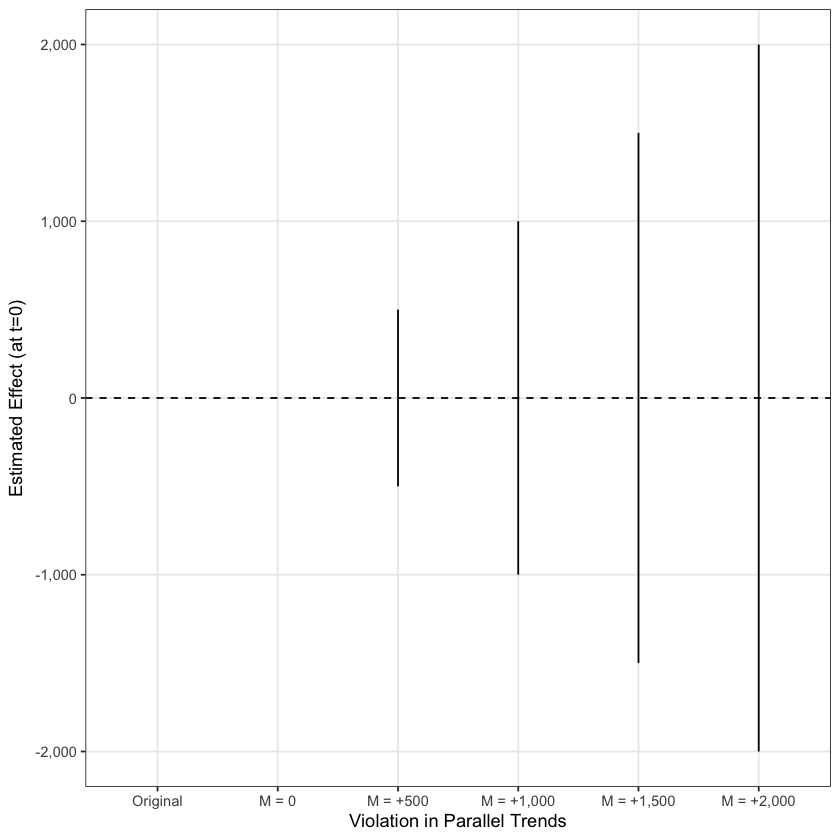

In [32]:
cs.hd.plot 

Q9. Discuss your findings and compare estimates from different estimators (e.g., are your results sensitive to different specifications or estimators? Are your results sensitive to violation of parallel trends assumptions?).

Q10. Reflect on this assignment. What did you find most challenging? What did you find most surprising?